## Инициализация

In [1082]:
import numpy as np
import math as mth

dt = 1
N = 5000
t = np.empty(N)

f = lambda x, t: np.array([x[0] + x[4] * t * mth.cos(x[2]),
                           x[1] + x[4] * t * mth.sin(x[2]),
                           x[2] + x[3] * t,
                           x[3],
                           x[4]])

df = lambda x, t: np.array([[1, 0, 0, 0,  t * mth.cos(x[2])],
                           [0, 1, 0, 0, t * mth.sin(x[2])],
                           [0, 0, 1, t, 0],
                           [0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 1]])

h = lambda x: np.array([x[0]])

dh = lambda x: np.array([[1, 0, 0, 0, 0]])

G = np.array([0, 0, 0, 0.01, 0.03])
Q = 0.0000000002

R = np.matrix([[10000]])


x_1 = np.empty(5)
P_1 = np.zeros((5, 5))
filterMassive = np.zeros((N, 5))


x_0 = np.array([0, 0, 0, 0.002, 27])
P_0 = np.array([[10, 0, 0, 0, 0],
                [0, 10, 0, 0, 0],
               [0, 0, 10, 0, 0],
               [0, 0, 0, 10000, 0],
               [0, 0, 0, 0, 10000]])

In [1083]:
import random as rnd

# Генерация зашумленного сенсора
istina = np.empty(N)
istina[0] = h(x_0) 
y = np.empty(N)
t[0] = 0
y[0] = h(x_0) 
x_i = x_0
x_ist = x_0

def makeNoise(G, Q):
    noise = np.empty(len(G))
    for i in range(len(G)):
        val = np.random.normal(0, Q)
        noise[i] = G[i] * val
    return noise

for i in range(1, N):
    t[i] = dt * i
    
    # Для построения настоящих значений сенсора
    noise = makeNoise(G, Q)
    x_k_1 = np.array(f(x_i, dt)) + noise# + с возмущением системы
    y[i] = h(np.array(f(x_i, dt))) + np.random.normal(0, R) # c шумом от сенсора
    x_i = x_k_1
    
    
    # Для построения истинных значений сенсора
    x_istina = np.array(f(x_ist, dt))
    istina[i] = h(np.array(f(x_ist, dt)))
    x_ist = x_istina

## Расширенный фильтр Калмана

In [1084]:
import math as mth

def customFlatten(z):
    l = np.empty(len(z))
    for i in range(len(z)):
        l[i] = float(z[i][0])
    return l

def predict(f, df, t, x_k, P_k, G_k = np.matrix([[0]]), Q_k = np.matrix([[0]])):
    x_k_1 = f(x_k, t)
    P_k_1 = df(x_k, t).dot(P_k).dot(df(x_k, t).T) + (G_k * Q_k).dot(G_k.T) 
    return x_k_1, P_k_1
    

def update(x_k, z_k_1, h, P_k, dH, R_k_1 = np.matrix([[0]])):
    Kk_1 = P_k.dot(dH(x_k).T) * np.linalg.inv(dH(x_k).dot(P_k).dot(dH(x_k).T) + R_k_1)  
    P_k_1 = (np.diag(np.ones(len(x_k))) - Kk_1 * dH(x_k)) * P_k   
    x_k_1 = x_k.T + (Kk_1 * (z_k_1 - h(x_k))).T
    return customFlatten(x_k_1.T), P_k_1, np.linalg.norm(Kk_1)

x = x_0
P = P_0

filterMassive[0] = x_0
gain = np.empty(N)
gain[0] = mth.inf

for i in range(1, N):
    x_k, P_k = predict(f, df, dt, x, P, G, Q)
    x_1, P_1, gain[i] = update(x_k, y[i], h, P_k, dh, R)
    
    x = x_1
    P = P_1
    filterMassive[i] = x_1

filt_y = []
for i in range(0, N):
    filt_y.append(h(filterMassive[i]))

# Results

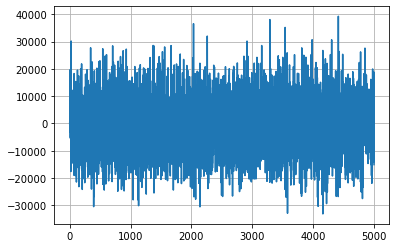

In [1085]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

filtr = np.empty(N)
for i in range(N):
    filtr[i] = filt_y[i]
    
plt.grid()
plt.plot(t, filtr - y)

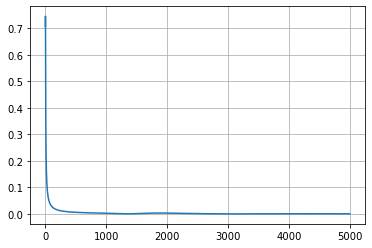

In [1086]:
plt.grid()
plt.plot(t, gain)

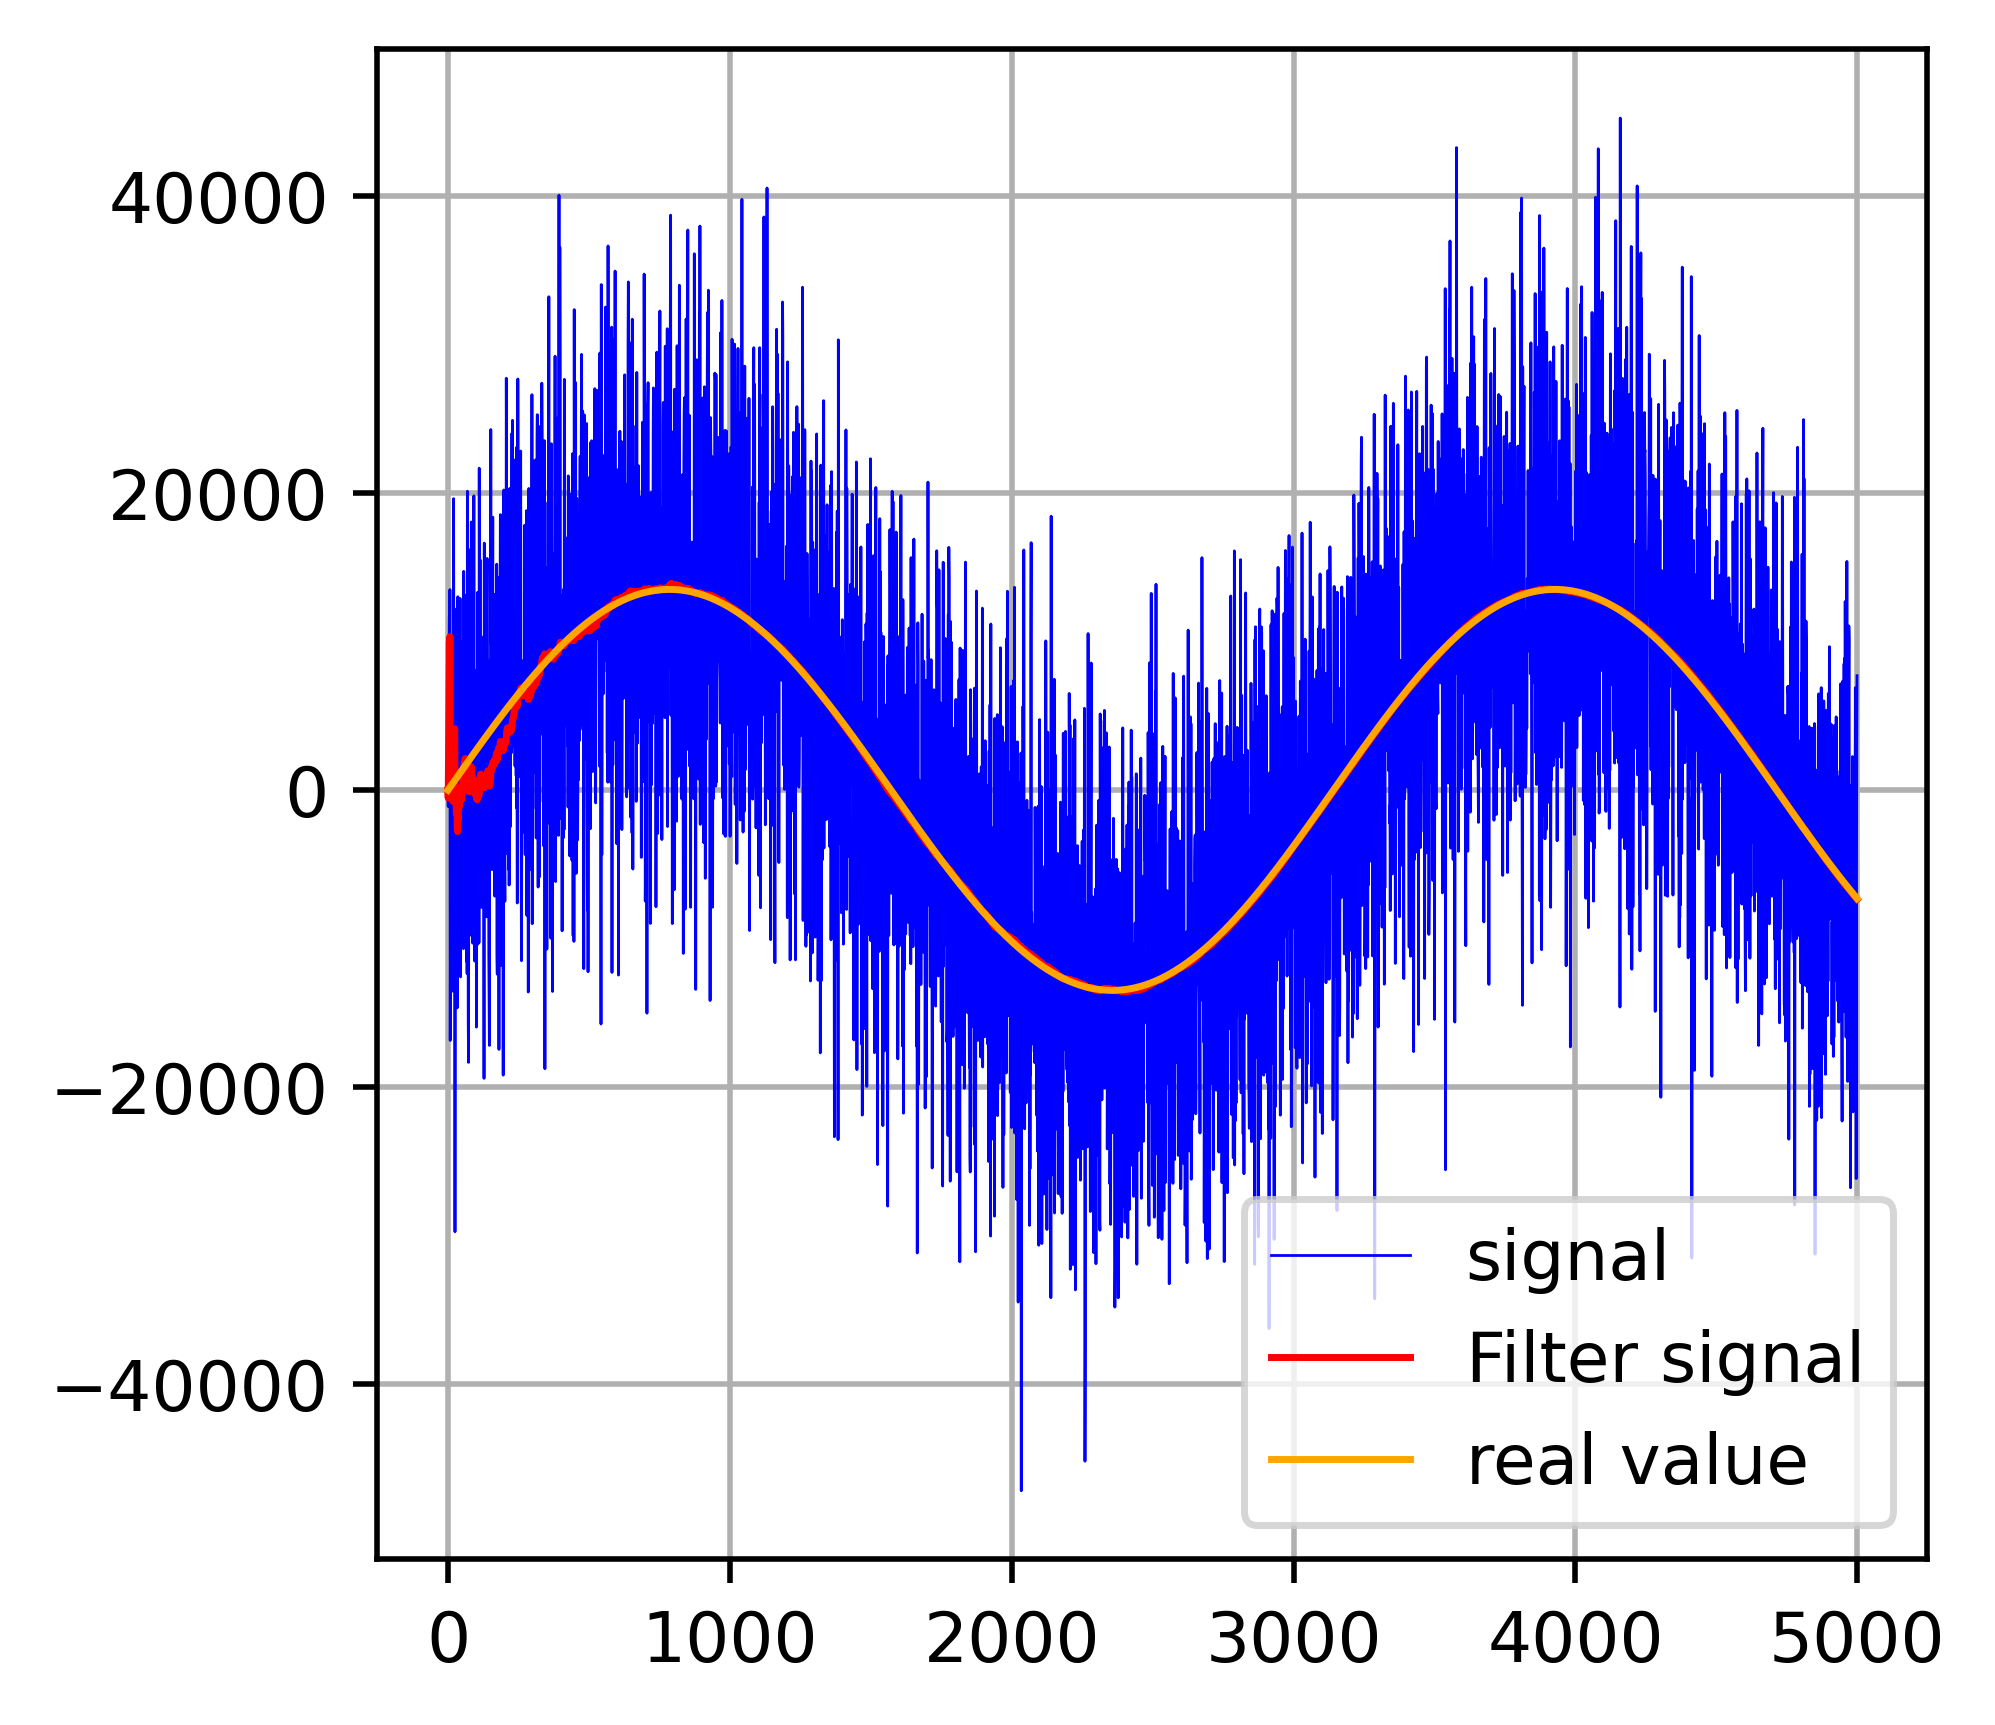

In [1087]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi = 500)
plt.grid()
plt.plot(t, y, 'b',label='signal', linewidth = 0.4)
plt.plot(t, filtr, 'r', label='Filter signal', linewidth = 1)
plt.plot(t, istina, 'orange', label='real value', linewidth = 1)
ax.legend()
plt.show()

In [1088]:
np.linalg.norm(y - istina) / np.linalg.norm(istina)

1.0713857324128115

In [1089]:
np.linalg.norm(filtr - istina) / np.linalg.norm(istina)

0.059043639353707274